In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116
     |████████████████████████████████| 9.4 MB 36.7 MB/s 
     |████████████████████████████████| 4.6 MB 46.6 MB/s 
     |████████████████████████████████| 3.2 MB 25.5 MB/s 
     |████████████████████████████████| 512 kB 32.6 MB/s 
     |████████████████████████████████| 280 kB 79.1 MB/s 


In [2]:
# Install our repo
# !git clone -b models "https://github.com/ab7289-tandon-nyu/GraphVision.git"
# !cp -r /content/GraphVision/src/ .

!pip install -q git+https://github.com/ab7289-tandon-nyu/GraphVision.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 121 kB 24.6 MB/s 
     |████████████████████████████████| 1.6 MB 48.8 MB/s 
     |████████████████████████████████| 83 kB 2.0 MB/s 


In [3]:
SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
from src.transforms import get_transforms
from src.datasets import get_datasets, get_dataloaders

transforms = get_transforms("cartesian")
train_dataset, valid_dataset, test_dataset = get_datasets(".data/", 
                        "CIFAR10", pre_transforms = None,
                        transforms = transforms)
BATCH_SIZE = 128

train_loader, valid_loader, test_loader = get_dataloaders(train_dataset,
                                                          valid_dataset,
                                                          test_dataset,
                                                          batch_size=(BATCH_SIZE, 1, 1),
                                                          drop_last = False)

Extracting .data/CIFAR10/raw/CIFAR10_v2.zip
Processing...
Done!


## Review batch attributes

In [5]:
sample_batch = next(iter(train_loader))

print()
print(sample_batch)
print("=====================================================================")

# Gather some statistics about the first graph.
print(f"Number of features:  {sample_batch.num_features}")
print(f"Number of node features: {sample_batch.num_node_features}")
print(f'Number of nodes: {sample_batch.num_nodes}')
print(f'Number of edges: {sample_batch.num_edges}')
print(f'Average node degree: {sample_batch.num_edges / sample_batch.num_nodes:.2f}')
print(f'Has isolated nodes: {sample_batch.has_isolated_nodes()}')
print(f'Has self-loops: {sample_batch.has_self_loops()}')


DataBatch(x=[14981, 3], edge_index=[2, 134829], edge_attr=[134829, 2], y=[128], pos=[14981, 2], edge_weight=[134829], batch=[14981], ptr=[129])
Number of features:  3
Number of node features: 3
Number of nodes: 14981
Number of edges: 134829
Average node degree: 9.00
Has isolated nodes: False
Has self-loops: True


In [6]:
# store edge dimension
edge_dim = sample_batch.edge_attr.size(-1)
edge_dim
# store number of features in graph batch
input_features = test_dataset.num_features
# store number of classes for classification
num_classes = test_dataset.num_classes

print(f"Number of features: {input_features}")
print(f"Number of classes: {num_classes}")
print(f"Edge Attr Dimension: {edge_dim}")

Number of features: 3
Number of classes: 10
Edge Attr Dimension: 2


In [7]:
from pathlib import Path

save_loc = "" # was "/content/drive/MyDrive/saved_models/" # put save location here
model_name = "GENConv_clus-false_BN_RELU_layer4_h128.pt"

file_path = save_loc + model_name
path = Path(file_path)
state_dict = None
if path.exists() and path.is_file():
  print("Found Save!")
  state_dict = torch.load(path)
else:
  print("Creating new Model")

Creating new Model


## Create our Model

In [9]:
from src.models import DeeperGCN
from src.engine import evaluate

hidden_features = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeeperGCN(
    input_features,
    num_classes,
    hidden_features,
    conv_type = "GEN",
    act = "relu",
    norm = "batch",
    num_layers = 4,
    use_cluster_pooling = False,
    readout = "mean",
    dropout = 0.25,
    edge_dim = edge_dim
).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
prev_loss = None
if state_dict is not None:
  print("Loading previously saved state dictionary")
  model.load_state_dict(state_dict)
  prev_loss, _ = evaluate(model.to(device), test_loader, criterion, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # was 0.01


In [10]:
params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f"There are {params:,} trainable parameters.")
print()
print(model)

There are 268,046 trainable parameters.

DeeperGCN(
  (fc_in): Linear(in_features=3, out_features=128, bias=True)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
  (out_act): ReLU(inplace=True)
  (layers): ModuleList(
    (0): DeepGCNLayer(block=res+)
    (1): DeepGCNLayer(block=res+)
    (2): DeepGCNLayer(block=res+)
    (3): DeepGCNLayer(block=res+)
  )
)


```
There are 268,046 trainable parameters.

DeeperGCN(
  (fc_in): Linear(in_features=3, out_features=128, bias=True)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
  (out_act): ReLU(inplace=True)
  (layers): ModuleList(
    (0): DeepGCNLayer(block=res+)
    (1): DeepGCNLayer(block=res+)
    (2): DeepGCNLayer(block=res+)
    (3): DeepGCNLayer(block=res+)
  )
)
```

## Train

In [11]:
from src.engine import train
from src.utils import calculate_accuracy

EPOCHS = 100
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []
best_loss = float('inf')
if prev_loss is not None:
  print(f"Training from previous best loss: {prev_loss}")
  best_loss = prev_loss

for epoch in range(1, EPOCHS + 1):
  print(f"\nEpoch: {epoch}\n")
  loss, acc = train(model, train_loader, criterion, optimizer, device)
  train_loss.append(loss)
  train_acc.append(acc)
  print(f"Train Loss: {train_loss[-1]:.3f}, Train Accuracy: {train_acc[-1]:.2f}")

  loss, acc = evaluate(model, valid_loader, criterion, device)
  valid_loss.append(loss)
  valid_acc.append(acc)
  print(f"Validation Loss: {valid_loss[-1]:.3f}, Validation Accuracy: {valid_acc[-1]:.2f}")

  if loss < best_loss:
    best_loss = loss
    torch.save(model.state_dict(), path)


Epoch: 1

Train Loss: 1.875, Train Accuracy: 0.31
Validation Loss: 1.855, Validation Accuracy: 0.32

Epoch: 2

Train Loss: 1.731, Train Accuracy: 0.37
Validation Loss: 1.965, Validation Accuracy: 0.32

Epoch: 3

Train Loss: 1.658, Train Accuracy: 0.40
Validation Loss: 2.004, Validation Accuracy: 0.29

Epoch: 4

Train Loss: 1.596, Train Accuracy: 0.42
Validation Loss: 1.984, Validation Accuracy: 0.32

Epoch: 5

Train Loss: 1.546, Train Accuracy: 0.44
Validation Loss: 2.072, Validation Accuracy: 0.28

Epoch: 6

Train Loss: 1.507, Train Accuracy: 0.45
Validation Loss: 1.912, Validation Accuracy: 0.34

Epoch: 7

Train Loss: 1.475, Train Accuracy: 0.47
Validation Loss: 1.892, Validation Accuracy: 0.33

Epoch: 8

Train Loss: 1.441, Train Accuracy: 0.48
Validation Loss: 1.887, Validation Accuracy: 0.33

Epoch: 9

Train Loss: 1.416, Train Accuracy: 0.49
Validation Loss: 2.245, Validation Accuracy: 0.29

Epoch: 10

Train Loss: 1.393, Train Accuracy: 0.50
Validation Loss: 2.080, Validation Accu

KeyboardInterrupt: ignored

Interrupted after 20 epochs because does not look promising.

Will revert to a learning rate of 0.01 (already trained in a separate notebook.)

## Evaluate on the Test set

In [12]:
# load best model
model.load_state_dict(torch.load(path))
test_loss, test_acc = evaluate(model.to(device), test_loader, criterion, device)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 1.866
Test Accuracy: 0.32%


## Plot Loss and Accuracy Curves

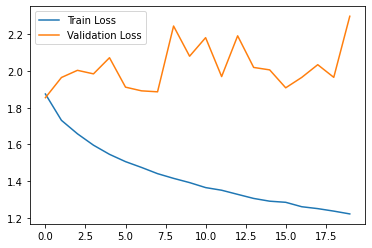

In [13]:
import matplotlib.pyplot as plt

x = [i for i in range(len(valid_loss))]

plt.plot(x, train_loss, label="Train Loss")
plt.plot(x, valid_loss, label="Validation Loss")
plt.legend()
plt.show()

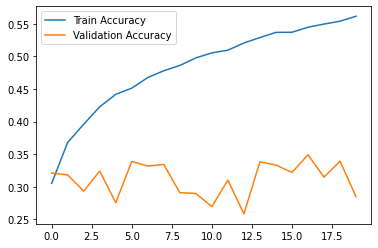

In [14]:
plt.plot(x, train_acc, label="Train Accuracy")
plt.plot(x, valid_acc, label="Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
# reaching epoch 19 (out of 1 to 100) at 29m